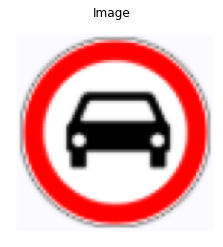

In [6]:
import cv2
import os
from matplotlib import pyplot as plt
import numpy as np

dataDir = '../dataset/images' # Change this, according to your images' directory path

img = cv2.imread(os.path.join(dataDir, 'redcircle.png')) # Change this, according to your image's path

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.title('Image')
plt.axis('off')
plt.show()

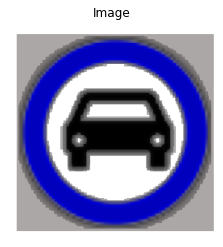

In [7]:
# Image Pre-processing

# Improve Lighting

imgYUV = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

imgYUV[:, :, 0] = cv2.equalizeHist(imgYUV[:, :, 0])

imgBetterLighting = cv2.cvtColor(imgYUV, cv2.COLOR_YUV2BGR)

# Smooth

imgWithMedianFilter = cv2.medianBlur(imgBetterLighting, 5)

plt.imshow(imgBetterLighting)
plt.title('Image')
plt.axis('off')
plt.show()


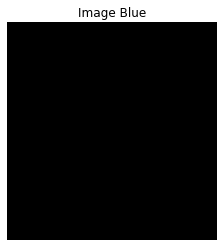

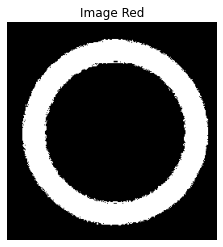

In [8]:
# Image Segmentation

img_hsv = cv2.cvtColor(imgWithMedianFilter, cv2.COLOR_BGR2HSV)

#set the bounds for the red hue
lower_red_n1 = np.array([0,70,60])
upper_red_n1 = np.array([10,255,255])

lower_red_n2 = np.array([170,70,60])
upper_red_n2 = np.array([100,255,255])

lower_blue_n3 = np.array([78,158,124])
upper_blue_n3 = np.array([138,255,255])

#create a mask using the bounds set
mask_1 = cv2.inRange(img_hsv, lower_red_n1, upper_red_n1)
mask_2 = cv2.inRange(img_hsv, lower_red_n2, upper_red_n2)

mask_red = mask_1 + mask_2

mask_blue = cv2.inRange(img_hsv, lower_blue_n3, upper_blue_n3)

img_red = cv2.cvtColor(mask_red, cv2.COLOR_BGR2RGB)
img_blue = cv2.cvtColor(mask_blue, cv2.COLOR_BGR2RGB)

plt.imshow(img_blue)
plt.title('Image Blue')
plt.axis('off')
plt.show()
plt.imshow(img_red)
plt.title('Image Red')
plt.axis('off')
plt.show()

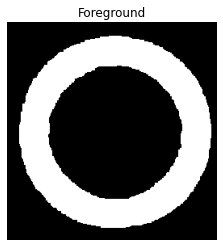

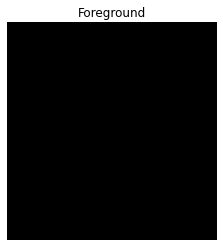

In [9]:
# Image Thresholding and Morphological Operations

# Red

imgGray_red = cv2.cvtColor(img_red, cv2.COLOR_RGB2GRAY)
ret, thresh_red = cv2.threshold(imgGray_red, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Removing Noise
kernel = np.ones((3, 3),np.uint8)
opening = cv2.morphologyEx(thresh_red, cv2.MORPH_OPEN, kernel, iterations = 2)

# Getting the background area
processed_red = cv2.dilate(opening,kernel,iterations=5)
processed_red = cv2.erode(processed_red,kernel,iterations=1)


# Blue

imgGray_blue = cv2.cvtColor(img_blue, cv2.COLOR_RGB2GRAY)
ret, thresh_blue = cv2.threshold(imgGray_blue, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Removing Noise
kernel = np.ones((5, 5),np.uint8)
opening = cv2.morphologyEx(thresh_blue, cv2.MORPH_OPEN, kernel, iterations = 2)

# Getting the background area
processed_blue = cv2.erode(opening,kernel,iterations=1)
processed_blue = cv2.dilate(opening,kernel,iterations=1)


plt.imshow(processed_red, cmap='gray')
plt.title('Foreground')
plt.axis('off')
plt.show()
plt.imshow(processed_blue, cmap='gray')
plt.title('Foreground')
plt.axis('off')
plt.show()

Found red circle sign
Found red circle sign


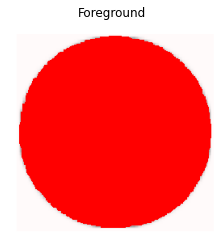

In [10]:
# Shape Recognition

# Red

# Octagon Detection
contours_red, hierarchy_red = cv2.findContours(processed_red, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

for cnt in contours_red:
    approx = cv2.approxPolyDP(cnt, 0.01*cv2.arcLength(cnt, True), True)
    #print(len(approx))

    if len(approx) == 8:
        print('Found STOP sign')
        img_red_contours = cv2.drawContours(img, [cnt], 0, (255,0,0), -1)

    elif len(approx) == 12:
        print('Found red circle sign')
        img_red_contours = cv2.drawContours(img, [cnt], 0, (255,0,0), -1)

# Apply the Hough circle transform
#detectionMethod = cv2.HOUGH_GRADIENT # corresponds to the canny filter
#resolutionFlag = 1 # same resolution as the original image
#minDistance = 20 # between the centers of the detected circles

# Convert to grayscale

#gray_red = cv2.cvtColor(processed_red, cv2.COLOR_GRAY2RGB)

# param1 and param2 are the thresholds passed to the detection method 
#img_red_circles = cv2.HoughCircles(imgGray_red, detectionMethod, resolutionFlag, minDistance, param1=200, param2=100, minRadius=0, maxRadius=0)
#img_red_circles = np.uint16(np.around(img_red_circles))

# Drawing the resulting circles
#for i in img_red_circles[0,:]: 
#    cv2.circle(imgGray_red,(i[0],i[1]),i[2],(0,255,0),2)

#plt.imshow(imgGray_red)
#plt.title('Hough Circle Transform Result')
#plt.axis('off')
#plt.show()

# Blue

contours_blue, hierarchy_blue = cv2.findContours(processed_blue, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

for cnt in contours_blue:
    approx = cv2.approxPolyDP(cnt, 0.01*cv2.arcLength(cnt, True), True)
    #print(len(approx))

    if len(approx) == 4:
        print('Found BLUE sign')
        img_blue_contours = cv2.drawContours(img, [cnt], 0, (0,0,255), -1)


debug = "red"

if debug=="red":
    plt.imshow(img_red_contours)
    plt.title('Foreground')
    plt.axis('off')
    plt.show()
elif debug == "blue":
    plt.imshow(img_blue_contours)
    plt.title('Foreground')
    plt.axis('off')
    plt.show()